Reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
import pandas as pd
import numpy as np
import re
import os
from os import path

# Gensim Package
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy for lemmatization
import spacy

# Plotting package
import matplotlib.pyplot as plt

#logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(mmessage)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [2]:
# Load files from directory
root_folder = "topicmodel_speeches"
files = os.listdir(root_folder)

## Read the speeches from the text file and load into a list

In [3]:
#load speeches into a list
speeches = [] 
file_names = []
for file in files:
    with open(path.join(root_folder, file), 'r') as file_desc:
       text = file_desc.read()
       speeches.append(text)
       file_names.append(file)


## Extract President Name and Date of Speech by parsing the file name
### example :  file name: "1789-10-03 George Washington.txt" - first part of file name is date of speech and second part is name of president

In [4]:
def extract_metaData(file_names):
    date_of_speech =[]
    president_names = []
    
    for file in file_names:
        data = file.replace('.txt','')
        data = data.split(' ',1)
        
        date_of_speech.append(data[0])
        president_names.append(data[1])

    return date_of_speech, president_names
    
# call the extract_metaData function to parse the file name and extract date of speech and name of president    
date_of_speech, president_names = extract_metaData(file_names)    

In [5]:
print("\n",date_of_speech[1],president_names[1],"\n",speeches[1][0:100])
print("\n",date_of_speech[80],president_names[80],"\n",speeches[80][0:100])
print("\n",date_of_speech[190],president_names[190],"\n",speeches[190][0:100])


 1789-10-03 George Washington 
 Whereas it is the duty of all Nations to acknowledge the providence of Almighty God to obey his will

 1820-11-14 James Monroe 
 Fellow Citizens of the Senate and of the House of Representatives: In communicating to you a just vi

 1903-12-07 Theodore Roosevelt 
 To the Senate and House of Representatives: The country is to be congratulated on the amount of subs


## Perform cleaning of speech data
\w (word character) matches any single letter, number or underscore    
\s+       One or more spaces

In [6]:
# clean speeches
def clean_speech(speech):
    speech = re.sub(r'[^\w\s]*', '', speech)  # replace any special characters or junk characters with ''
    speech = re.sub(r'[\s]+', ' ', speech)    # remove new line character
    speech = speech.lower().strip()           # lowercase the text
    
    return speech


In [7]:
clean_speeches = []
for speech in speeches:
    speech = clean_speech(speech)
    clean_speeches.append(speech)


In [8]:
print("\n",date_of_speech[1],president_names[1],"\n",clean_speeches[1][0:100])
print("\n",date_of_speech[80],president_names[80],"\n",clean_speeches[80][0:100])
print("\n",date_of_speech[190],president_names[190],"\n",clean_speeches[190][0:100])


 1789-10-03 George Washington 
 whereas it is the duty of all nations to acknowledge the providence of almighty god to obey his will

 1820-11-14 James Monroe 
 fellow citizens of the senate and of the house of representatives in communicating to you a just vie

 1903-12-07 Theodore Roosevelt 
 to the senate and house of representatives the country is to be congratulated on the amount of subst


## Tokenize the words and removing the punctuations and unnecassary characters 
We will use Gensim's simple_preprocess() function for this task

In [9]:
def tokenize_to_words(clean_speeches):
    for speech in clean_speeches:
        yield(gensim.utils.simple_preprocess(str(speech), deacc=True))  # deacc=True removes punctuations
                    

In [10]:
speech_words = list(tokenize_to_words(clean_speeches))

In [11]:
print(speech_words[0][:100])

['fellow', 'citizens', 'of', 'the', 'senate', 'and', 'the', 'house', 'of', 'representatives', 'among', 'the', 'vicissitudes', 'incident', 'to', 'life', 'no', 'event', 'could', 'have', 'filled', 'me', 'with', 'greater', 'anxieties', 'than', 'that', 'of', 'which', 'the', 'notification', 'was', 'transmitted', 'by', 'your', 'order', 'and', 'received', 'on', 'the', 'fourteenth', 'day', 'of', 'the', 'present', 'month', 'on', 'the', 'one', 'hand', 'was', 'summoned', 'by', 'my', 'country', 'whose', 'voice', 'can', 'never', 'hear', 'but', 'with', 'veneration', 'and', 'love', 'from', 'retreat', 'which', 'had', 'chosen', 'with', 'the', 'fondest', 'predilection', 'and', 'in', 'my', 'flattering', 'hopes', 'with', 'an', 'immutable', 'decision', 'as', 'the', 'asylum', 'of', 'my', 'declining', 'years', 'retreat', 'which', 'was', 'rendered', 'every', 'day', 'more', 'necessary', 'as', 'well']


## Create bigram model
Bigrams are two words frequently occurring together in the document.    

In [12]:
bigram = gensim.models.Phrases(speech_words,min_count=5, threshold=100) #higher threshold will give few phrases

bigram_mod = gensim.models.phrases.Phraser(bigram)

print(bigram_mod[speech_words[0]])

['fellow_citizens', 'of', 'the', 'senate', 'and', 'the', 'house', 'of', 'representatives', 'among', 'the', 'vicissitudes', 'incident', 'to', 'life', 'no', 'event', 'could', 'have', 'filled', 'me', 'with', 'greater', 'anxieties', 'than', 'that', 'of', 'which', 'the', 'notification', 'was', 'transmitted', 'by', 'your', 'order', 'and', 'received', 'on', 'the', 'fourteenth', 'day', 'of', 'the', 'present', 'month', 'on', 'the', 'one', 'hand', 'was', 'summoned', 'by', 'my', 'country', 'whose', 'voice', 'can', 'never', 'hear', 'but', 'with', 'veneration', 'and', 'love', 'from', 'retreat', 'which', 'had', 'chosen', 'with', 'the', 'fondest', 'predilection', 'and', 'in', 'my', 'flattering', 'hopes', 'with', 'an', 'immutable', 'decision', 'as', 'the', 'asylum', 'of', 'my', 'declining', 'years', 'retreat', 'which', 'was', 'rendered', 'every', 'day', 'more', 'necessary', 'as', 'well', 'as', 'more', 'dear', 'to', 'me', 'by', 'the', 'addition', 'of', 'habit', 'to', 'inclination', 'and', 'of', 'freque

## Remove stop words, make bigrams and lemmatize the words

In [13]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [14]:
# Define functions for stopwords, bigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
speech_words_nostops = remove_stopwords(speech_words)

# Form Bigrams
speech_words_bigrams = make_bigrams(speech_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
speech_lemmatized = lemmatization(speech_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [16]:
print(speech_lemmatized[0])

['senate', 'house', 'representative', 'vicissitude', 'incident', 'life', 'event', 'fill', 'great', 'anxiety', 'notification', 'transmit', 'order', 'receive', 'fourteenth', 'day', 'present', 'month', 'hand', 'summon', 'country', 'voice', 'never', 'hear', 'veneration', 'love', 'retreat', 'choose', 'fondest', 'predilection', 'flatter', 'hope', 'immutable', 'decision', 'asylum', 'decline', 'year', 'retreat', 'render', 'day', 'necessary', 'dear', 'addition', 'habit', 'inclination', 'frequent', 'interruption', 'health', 'gradual', 'waste', 'commit', 'time', 'hand', 'magnitude', 'difficulty', 'trust', 'voice', 'country', 'call', 'sufficient', 'awaken', 'wise', 'experienced', 'citizen', 'distrustful', 'scrutiny', 'qualification', 'overwhelm', 'dispondence', 'inherit', 'inferior', 'endowment', 'nature', 'unpractised', 'duty', 'civil', 'administration', 'peculiarly', 'conscious', 'deficencie', 'conflict', 'emotion', 'dare', 'aver', 'faithful', 'study', 'collect', 'duty', 'appreciation', 'circums

# Topic modelling
###  LDA   
Term Document Freq: (word_id, word_frequency)

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(speech_lemmatized)
# id2word.compactify()

# Create Corpus
texts = speech_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [18]:
# View
print(id2word[0], "\n", corpus[0])

accomplish 
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 2), (60, 2), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 3), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 5), (99, 1), (100, 1), (101, 2), (102, 2), (103, 1), (104, 2), (105, 1), (106, 2), (107, 1), (108, 1), (109, 

In [19]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

### Build the topic model

In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# Print the Keyword in the 10 topics
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(1,
  '0.000*"gratifiedbut" + 0.000*"growthwhile" + 0.000*"glimpse" + '
  '0.000*"globeswept" + 0.000*"governmentand" + 0.000*"founda" + '
  '0.000*"hardhitting" + 0.000*"hammarskioldor" + 0.000*"flowsha" + '
  '0.000*"habitforme"'),
 (12,
  '0.000*"gratifiedbut" + 0.000*"growthwhile" + 0.000*"glimpse" + '
  '0.000*"globeswept" + 0.000*"governmentand" + 0.000*"founda" + '
  '0.000*"hardhitting" + 0.000*"hammarskioldor" + 0.000*"flowsha" + '
  '0.000*"habitforme"'),
 (18,
  '0.000*"gratifiedbut" + 0.000*"growthwhile" + 0.000*"glimpse" + '
  '0.000*"globeswept" + 0.000*"governmentand" + 0.000*"founda" + '
  '0.000*"hardhitting" + 0.000*"hammarskioldor" + 0.000*"flowsha" + '
  '0.000*"habitforme"'),
 (11,
  '0.000*"gratifiedbut" + 0.000*"growthwhile" + 0.000*"glimpse" + '
  '0.000*"globeswept" + 0.000*"governmentand" + 0.000*"founda" + '
  '0.000*"hardhitting" + 0.000*"hammarskioldor" + 0.000*"flowsha" + '
  '0.000*"habitforme"'),
 (15,
  '0.000*"gratifiedbut" + 0.000*"growthwhile" + 0.0

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=speech_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -11.33381190328704

Coherence Score:  0.4720110915790855


# Optimize the number of topics

In [57]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    perplexity= []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                           id2word=dictionary,
                                                           num_topics=num_topics, 
                                                           random_state=100,
                                                           update_every=1,
                                                           chunksize=100,
                                                           passes=20,
                                                           alpha='auto',
                                                           per_word_topics=True)        
        
        model_list.append(model)
        perplexity.append(model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values, perplexity

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
# Can take a long time to run.
model_list, coherence_values, perplexity = compute_coherence_values(dictionary=id2word, \
                                                        corpus=corpus, texts=speech_lemmatized, start=2, limit=50, step=2)

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


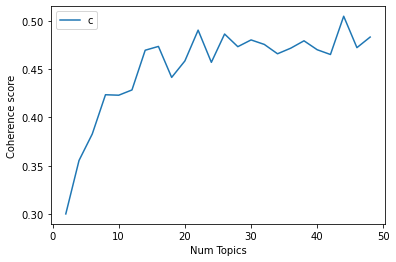

In [59]:
# Show graph
limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [60]:
iterations = 0
for p, cv, i in zip(perplexity, coherence_values, x):
    print("Iteration: ", iterations, ", Number of Topics : ", i, ", Perplexity: ", p, ", CV Score: ", cv, "\n")
    iterations +=1
    

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Iteration:  0 , Number of Topics :  2 , Perplexity:  -7.8540021122536885 , CV Score:  0.30005321950674385 

Iteration:  1 , Number of Topics :  4 , Perplexity:  -7.8478240119899425 , CV Score:  0.35538471806519 

Iteration:  2 , Number of Topics :  6 , Perplexity:  -7.8648957035204115 , CV Score:  0.38278240772543803 

Iteration:  3 , Number of Topics :  8 , Perplexity:  -7.954597064765758 , CV Score:  0.4234125956047471 

Iteration:  4 , Number of Topics :  10 , Perplexity:  -8.238900789123726 , CV Score:  0.42292204458256955 

Iteration:  5 , Number of Topics :  12 , Perplexity:  -8.745307825518235 , CV Score:  0.42836291342493293 

Iteration:  6 , Number of Topics :  14 , Perplexity:  -9.362685397877462 , CV Score:  0.4694816953479912 

Iteration:  7 , Number of Topics :  16 , Perplexity:  -10.013908009536388 , CV Score:  0.4734227620132248 

Iteration:  8 , Number of Topics :  18 , Perplexity:  -10.38941493947096 , CV Score:  0.4413568710111486 

Iteration:  9 , Number of Topics : 

# Visualization

In [71]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

pyLDAvis.enable_notebook(local=True)


D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
D:\anaconda3\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [77]:
vis = pyLDAvis.gensim.prepare(model_list[7], corpus, id2word,mds='mmds')
pyLDAvis.show(vis)

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
D:\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
D:\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing thi


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8894/    [Ctrl-C to exit]


127.0.0.1 - - [16/Apr/2021 18:26:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Apr/2021 18:26:15] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [16/Apr/2021 18:26:15] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [16/Apr/2021 18:26:15] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...
